# Seed Classification



<a id = 'import'></a>
### Importing the Dataset and the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import itertools
import time
import copy

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        seed = 123
np.random.seed(seed)
def show_plots(history, plot_title=None, fig_size=None):
    """ Useful function to view plot of loss values & accuracies across the various epochs
        Works with the history object returned by the train_model(...) call """
    assert type(history) is dict
    # NOTE: the history object should always have loss & acc (for training data), but MAY have
    # val_loss & val_acc for validation data
    loss_vals = history['loss']
    val_loss_vals = history['val_loss'] if 'val_loss' in history.keys() else None
    epochs = range(1, len(history['loss']) + 1)

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=((16, 4) if fig_size is None else fig_size))

    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy', marker='o', linestyle=' ', label='Training Loss')
    if val_loss_vals is not None:
        ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
        ax[0].set_title('Training & Validation Loss')
        ax[0].legend(loc='best')
    else:
        ax[0].set_title('Training Loss')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].grid(True)

    # plot accuracies
    acc_vals = history['acc']  if 'acc' in history.keys() else None
    val_acc_vals = history['val_acc'] if 'val_acc' in history.keys() else None
    if acc_vals is not None:
        ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    if val_acc_vals is not None:
        ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
        ax[1].set_title('Training & Validation Accuracy')
        ax[1].legend(loc='best')
    else:
        ax[1].set_title('Training Accuracy')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)

    if plot_title is not None:
        plt.suptitle(plot_title)

    plt.show()
    plt.savefig("metrics.png")
    plt.close()

    # delete locals from heap before exiting (to save some memory!)
    del loss_vals, epochs
    if val_loss_vals is not None:
        del val_loss_vals

**Preparing the Training and Testing Dataset for the model**

In [2]:
import shutil
path = '/dataset'
shutil.os.mkdir(path)

In [3]:
path = '/dataset/train'
shutil.os.mkdir(path)

In [4]:
path = '/dataset/train/'
data_dir = '../input/v2-plant-seedlings-dataset/'
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)
copytree(data_dir, path)

In [ ]:
print(os.listdir(path))

In [5]:
shutil.rmtree('/dataset/train/nonsegmentedv2')

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

**Preparing the models with proper architectures**

In [56]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/dataset/train/'

# Models to choose from [inception, mobilenet, resnet, squeezenet, densenet, vgg, alexnet]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 12

# Batch size for training
batch_size = 64

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

**Preparing the Transforms and dataset**

In [39]:
#Prepare transforms and dataset

if model_name == 'inception':
    #inception requires 299 cropped size
    batchsize = 64
    data_transforms = transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(299),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
else:
    batchsize = 64
    data_transforms = transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])    

dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

**Spliting the dataset into Training and Validation sets**

In [40]:
#Split dataset into training and validation sets
train_set, val_set = torch.utils.data.random_split(dataset, [4039, 1500])
print(len(train_set))

4039


**Loading the Training and Validation Dataset**

In [41]:
train_loader = torch.utils.data.DataLoader(train_set, batchsize, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batchsize)
dataloaders_dict = {'train':train_loader, 'val':valid_loader}

**Checking if CUDA is available or, not!**

The NVIDIA CUDAÂ® Deep Neural Network library (cuDNN) is a GPU-accelerated library of primitives for deep neural networks. It allows them to focus on training neural networks and developing software applications rather than spending time on low-level GPU performance tuning.

In [10]:
# check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<a id = 'arch'></a>
### Setting the Model Architectures

1. ResNet
2. AlexNet
3. vgg
4. MobileNet
5. SqueezeNet
6. Inception
7. DenseNet

In [42]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "mobilenet":
        """ mobilenet_v2
        """
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

**Preparing the model to run**

In [57]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Sending the model to GPU**

In [58]:
#Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
#optimizer_ft = optim.Adam(params_to_update, lr=0.001)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


<a id = 'eval'></a>
### Evaluating the Deployment of the Architectures

In [14]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=100, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    # mode we calculate the loss by summing the final output and the auxiliary output
                    # but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    history = {'loss':train_loss_history, 'acc':train_acc_history, 'val_loss':val_loss_history, 'val_acc':val_acc_history}
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,history

In [59]:
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model, history = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 2.3538 Acc: 0.2062
val Loss: 2.1375 Acc: 0.3020

Epoch 1/49
----------
train Loss: 2.0040 Acc: 0.3721
val Loss: 1.9175 Acc: 0.3987

Epoch 2/49
----------
train Loss: 1.8292 Acc: 0.4387
val Loss: 1.7395 Acc: 0.4647

Epoch 3/49
----------
train Loss: 1.6932 Acc: 0.4932
val Loss: 1.6572 Acc: 0.5060

Epoch 4/49
----------
train Loss: 1.6029 Acc: 0.5184
val Loss: 1.5444 Acc: 0.5353

Epoch 5/49
----------
train Loss: 1.5114 Acc: 0.5491
val Loss: 1.4703 Acc: 0.5713

Epoch 6/49
----------
train Loss: 1.4715 Acc: 0.5553
val Loss: 1.4727 Acc: 0.5320

Epoch 7/49
----------
train Loss: 1.3930 Acc: 0.5821
val Loss: 1.3761 Acc: 0.5953

Epoch 8/49
----------
train Loss: 1.3552 Acc: 0.5910
val Loss: 1.3518 Acc: 0.5873

Epoch 9/49
----------
train Loss: 1.3362 Acc: 0.5967
val Loss: 1.3264 Acc: 0.5800

Epoch 10/49
----------
train Loss: 1.2958 Acc: 0.6115
val Loss: 1.2842 Acc: 0.6013

Epoch 11/49
----------
train Loss: 1.2765 Acc: 0.6110
val Loss: 1.2694 Acc: 0.6127

Ep

<a id = 'pred'></a>
### Getting all the predictions on the Validation Set

In [46]:
#getting all the predictions on the valid set
def eval_predict(model,dataloaders_dict, phase):
    model.eval()
    all_predict = torch.tensor([], device=device)
    all_labels = torch.tensor([], device=device)
    with torch.no_grad():
        for inputs, labels in dataloaders_dict[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_predict = torch.cat((all_predict, preds), 0)
            all_labels = torch.cat((all_labels, labels), 0)
    return all_predict, all_labels

phase = 'val'
y_pred,y_true = eval_predict(model, dataloaders_dict, phase)

y_pred = y_pred.cpu().numpy()
y_true = y_true.cpu().numpy()

<a id = 'conf'></a>
### Creating the Confusion-Matrix

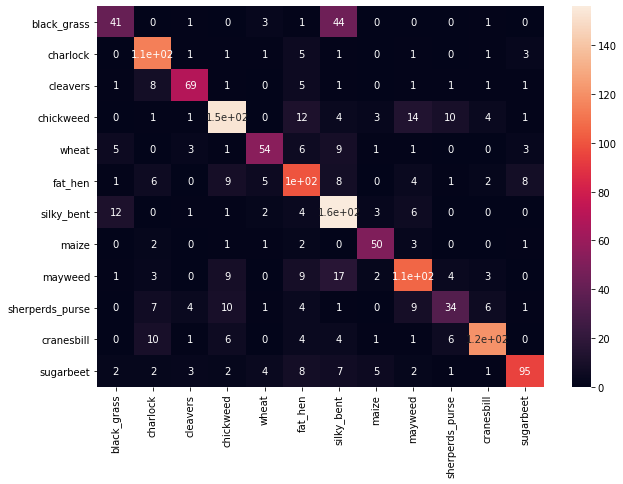

In [47]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
with open('confusion_matrix.npy', 'wb') as f:
    np.save(f, cnf_matrix)

#with open('test.npy', 'rb') as f:
#    a = np.load(f)
    
df_cm = pd.DataFrame(cnf_matrix, index = ["black_grass", "charlock","cleavers", "chickweed","wheat","fat_hen","silky_bent","maize","mayweed","sherperds_purse","cranesbill","sugarbeet"],
                  columns = ["black_grass", "charlock","cleavers", "chickweed","wheat","fat_hen","silky_bent","maize","mayweed","sherperds_purse","cranesbill","sugarbeet"])
plt.figure(figsize = (10,7))
plot = sns.heatmap(df_cm, annot=True)
fig = plot.get_figure()
fig.savefig("confusionmatrix.png")

<a id = 'plot'></a>
### Plotting the Loss and Accuracy on the Training and Validation set

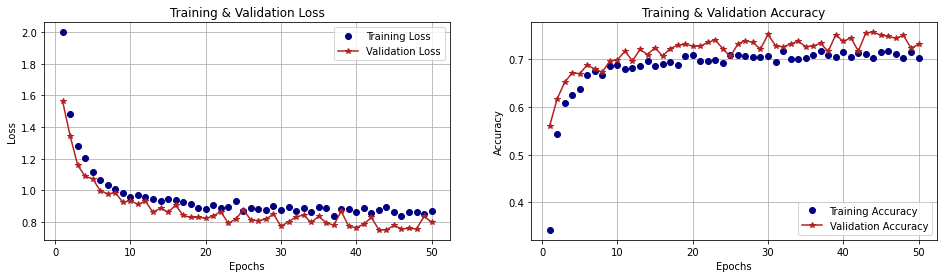

In [48]:
#Plot loss and accuracies
show_plots(history, plot_title=None, fig_size=None)

***********************************************